In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from CASPEALR1 import CAS_utils
cas = CAS_utils('C:\\Users\\吴宇翔\\Desktop\\CAS-PEAL-R1')

In [2]:
###########################################################
# 模型：训练集   注册：训练集   探测：训练集
image_paths = cas.load_training_set_image_name()
images = []
sum_image = np.zeros((480, 360))
i = 0
for PATH in image_paths:
    image = io.imread('C:\\Users\\吴宇翔\\Desktop\\CAS-PEAL-R1\\' + PATH)
    # 当i循环到3时，存储该人4幅图像的平均图像
    if i is 3:
        i = 0
        sum_image += image
        images.append(sum_image / 4)
        sum_image = np.zeros((480, 360))
        
    else:
        i += 1
        sum_image += image
images = np.array(images)
# step.1 张量化 --->  (300，172800) (N, D)
N, D = 300, 480*360
images = images.reshape((N, -1))

# step.2 去中心化
images_centered = images - np.mean(images, axis=0)

assert np.allclose(images_centered.mean(), 0.0)

# step.3 求协方差矩阵(D, D)的特征值   ---> 根据特征值找出方差最大的
[eigenvalues, eigenvectors] = np.linalg.eig(np.dot(images_centered, images_centered.T) / N)
seq_values = np.argsort(-eigenvalues)
image_centered_eigenvalues = np.array([eigenvalues[seq_values[i]] for i in seq_values])  # [300， ]
image_centered_eigenvectors = np.array([eigenvectors[:, seq_values[i]] for i in seq_values]) # [300, 300]
eigenfaces = np.dot(images_centered.T, image_centered_eigenvectors) # [172800, 300]
for i in range(N):
    eigenfaces[:, i] = eigenfaces[:, i] / np.linalg.norm(eigenfaces[:, 1])

assert image_centered_eigenvalues.shape == (N, )
assert eigenfaces.shape == (D, N)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


In [5]:
eigenfaces[:, :n_components].shape

(172800, 50)

In [5]:
from cv2 import PCACompute
_, eigenfaces = PCACompute(images, mean=None, maxComponents=50)

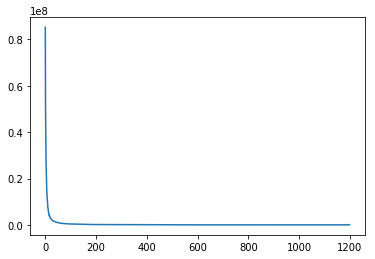

In [3]:
plt.plot(image_centered_eigenvalues)
plt.show()

In [3]:

''' step.2  ==>  作注册人脸矩阵
    基本配置：图像矩阵
             以及对应的标签数组
'''
gallery_paths = cas.load_gallery_image_name()
gallery_images = []
gallery_labels = []
for PATH in gallery_paths:
    image = io.imread('C:\\Users\\吴宇翔\\Desktop\\CAS-PEAL-R1\\' + PATH)
    gallery_images.append(image)
    gallery_labels.append(int(PATH.split('_')[1]))
gallery_images = np.array(gallery_images)
gallery_images = gallery_images.reshape((gallery_images.shape[0], -1))
gallery_labels = np.array(gallery_labels)

"""
    降维：
    1. 去中心化
    2. 和(D, n_components)的eigenfaces矩阵相乘得到投影坐标矩阵
"""
# 根据上面的奇异值曲线图试验多少个特征向量是重构的最佳结果
n_components = 50
#   1. first substract the mean
gallery_images_mean = np.mean(gallery_images, axis=0)
gallery_images_centered = gallery_images - gallery_images_mean
#   2. then project onto a subspace of dimension `n_components` using `self.W_pca`
gallery_images_centered_proj = np.dot(gallery_images_centered, eigenfaces[:, :n_components])
assert gallery_images_centered_proj.shape == (gallery_images.shape[0], n_components)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


In [5]:
'''
    3.1 ==> Probe of Accessory
'''

probe_Accessory_paths = cas.load_Probe_Sets_image_name('Accessory')
probe_Accessory_images = []
probe_Accessory_labels = []
for PATH in probe_Accessory_paths:
    image = io.imread('C:\\Users\\吴宇翔\\Desktop\\CAS-PEAL-R1\\' + PATH)
    probe_Accessory_images.append(image)
    probe_Accessory_labels.append(int(PATH.split('_')[1]))
probe_Accessory_images = np.array(probe_Accessory_images)
probe_Accessory_images = probe_Accessory_images.reshape((probe_Accessory_images.shape[0], -1))
probe_Accessory_labels = np.array(probe_Accessory_labels)

# 取前50个特征向量
n_components = 50
#   1. first substract the mean
probe_Accessory_images_mean = np.mean(probe_Accessory_images, axis=0)
probe_Accessory_images_centered = probe_Accessory_images - probe_Accessory_images_mean
#   2. then project onto a subspace of dimension `n_components` using `self.W_pca`
probe_Accessory_images_centered_proj = np.dot(probe_Accessory_images_centered, eigenfaces[:, :n_components])
assert probe_Accessory_images_centered_proj.shape == (probe_Accessory_images.shape[0], n_components)

# Calculate Precision
dists = np.zeros((probe_Accessory_images_centered_proj.shape[0], gallery_images_centered_proj.shape[0]))
dists += np.sum(probe_Accessory_images_centered_proj * probe_Accessory_images_centered_proj, axis=1, keepdims=True)
dists += np.sum((gallery_images_centered_proj * gallery_images_centered_proj).T, axis=0, keepdims=True)
dists -= 2 * np.dot(probe_Accessory_images_centered_proj, gallery_images_centered_proj.T)
# 根据距离矩阵选出最小的距离
closest_prediciton = np.zeros((probe_Accessory_images_centered_proj.shape[0], ))
right_prediciton = 0
for i in range(dists.shape[0]):
    closest_prediciton[i] = gallery_labels[np.argmin(dists[i])]
    if closest_prediciton[i] == probe_Accessory_labels[i]:
        right_prediciton += 1
print("------------------Correct:  ", right_prediciton)
print("------------------Sum:  ", dists.shape[0])
print("------------------Precision:  ", right_prediciton / dists.shape[0])

C:\ProgramData\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


------------------Correct:   13
------------------Sum:   2285
------------------Precision:   0.0056892778993435445


In [7]:
'''
    3.2 ==> Probe of Expression
'''

probe_Aging_paths = cas.load_Probe_Sets_image_name('Expression')
probe_Aging_images = []
probe_Aging_labels = []
for PATH in probe_Aging_paths:
    image = io.imread('C:\\Users\\吴宇翔\\Desktop\\CAS-PEAL-R1\\' + PATH)
    probe_Aging_images.append(image)
    probe_Aging_labels.append(int(PATH.split('_')[1]))
probe_Aging_images = np.array(probe_Aging_images)
probe_Aging_images = probe_Aging_images.reshape((probe_Aging_images.shape[0], -1))
probe_Aging_labels = np.array(probe_Aging_labels)

# 取前50个特征向量
n_components = 50
#   1. first substract the mean
probe_Aging_images_mean = np.mean(probe_Aging_images, axis=0)
probe_Aging_images_centered = probe_Aging_images - probe_Aging_images_mean
#   2. then project onto a subspace of dimension `n_components` using `self.W_pca`
probe_Aging_images_centered_proj = np.dot(probe_Aging_images_centered, eigenfaces[:, :n_components])
assert probe_Aging_images_centered_proj.shape == (probe_Aging_images.shape[0], n_components)

# Calculate Precision
dists = np.zeros((probe_Aging_images_centered_proj.shape[0], gallery_images_centered_proj.shape[0]))
dists += np.sum(probe_Aging_images_centered_proj * probe_Aging_images_centered_proj, axis=1, keepdims=True)
dists += np.sum((gallery_images_centered_proj * gallery_images_centered_proj).T, axis=0, keepdims=True)
dists -= 2 * np.dot(probe_Aging_images_centered_proj, gallery_images_centered_proj.T)
# 根据距离矩阵选出最小的距离
closest_prediciton = np.zeros((probe_Aging_images_centered_proj.shape[0], ))
right_prediciton = 0
for i in range(dists.shape[0]):
    closest_prediciton[i] = gallery_labels[np.argmin(dists[i])]
    if closest_prediciton[i] == probe_Aging_labels[i]:
        right_prediciton += 1
print("------------------Correct:  ", right_prediciton)
print("------------------Sum:  ", dists.shape[0])
print("------------------Precision:  ", right_prediciton / dists.shape[0])

------------------Correct:   696
------------------Sum:   1570
------------------Precision:   0.44331210191082804


In [9]:
'''
    3.3 ==> Probe of Background
'''

probe_Background_paths = cas.load_Probe_Sets_image_name('Background')
probe_Background_images = []
probe_Background_labels = []
for PATH in probe_Background_paths:
    image = io.imread('C:\\Users\\吴宇翔\\Desktop\\CAS-PEAL-R1\\' + PATH)
    probe_Background_images.append(image)
    probe_Background_labels.append(int(PATH.split('_')[1]))
probe_Background_images = np.array(probe_Background_images)
probe_Background_images = probe_Background_images.reshape((probe_Background_images.shape[0], -1))
probe_Background_labels = np.array(probe_Background_labels)

# 取前50个特征向量
n_components = 50
#   1. first substract the mean
probe_Background_images_mean = np.mean(probe_Background_images, axis=0)
probe_Background_images_centered = probe_Background_images - probe_Background_images_mean
#   2. then project onto a subspace of dimension `n_components` using `self.W_pca`
probe_Background_images_centered_proj = np.dot(probe_Background_images_centered, eigenfaces[:, :n_components])
assert probe_Background_images_centered_proj.shape == (probe_Background_images.shape[0], n_components)

# Calculate Precision
dists = np.zeros((probe_Background_images_centered_proj.shape[0], gallery_images_centered_proj.shape[0]))
dists += np.sum(probe_Background_images_centered_proj * probe_Background_images_centered_proj, axis=1, keepdims=True)
dists += np.sum((gallery_images_centered_proj * gallery_images_centered_proj).T, axis=0, keepdims=True)
dists -= 2 * np.dot(probe_Background_images_centered_proj, gallery_images_centered_proj.T)
# 根据距离矩阵选出最小的距离
closest_prediciton = np.zeros((probe_Background_images_centered_proj.shape[0], ))
right_prediciton = 0
for i in range(dists.shape[0]):
    closest_prediciton[i] = gallery_labels[np.argmin(dists[i])]
    if closest_prediciton[i] == probe_Background_labels[i]:
        right_prediciton += 1
print("------------------Correct:  ", right_prediciton)
print("------------------Sum:  ", dists.shape[0])
print("------------------Precision:  ", right_prediciton / dists.shape[0])

------------------Correct:   6
------------------Sum:   552
------------------Precision:   0.010869565217391304


In [10]:
'''
    3.4 ==> Probe of Distance
'''

probe_Distance_paths = cas.load_Probe_Sets_image_name('Distance')
probe_Distance_images = []
probe_Distance_labels = []
for PATH in probe_Distance_paths:
    image = io.imread('C:\\Users\\吴宇翔\\Desktop\\CAS-PEAL-R1\\' + PATH)
    probe_Distance_images.append(image)
    probe_Distance_labels.append(int(PATH.split('_')[1]))
probe_Distance_images = np.array(probe_Distance_images)
probe_Distance_images = probe_Distance_images.reshape((probe_Distance_images.shape[0], -1))
probe_Distance_labels = np.array(probe_Distance_labels)

# 取前50个特征向量
n_components = 50
#   1. first substract the mean
probe_Distance_images_mean = np.mean(probe_Distance_images, axis=0)
probe_Distance_images_centered = probe_Distance_images - probe_Distance_images_mean
#   2. then project onto a subspace of dimension `n_components` using `self.W_pca`
probe_Distance_images_centered_proj = np.dot(probe_Distance_images_centered, eigenfaces[:, :n_components])
assert probe_Distance_images_centered_proj.shape == (probe_Distance_images.shape[0], n_components)

# Calculate Precision
dists = np.zeros((probe_Distance_images_centered_proj.shape[0], gallery_images_centered_proj.shape[0]))
dists += np.sum(probe_Distance_images_centered_proj * probe_Distance_images_centered_proj, axis=1, keepdims=True)
dists += np.sum((gallery_images_centered_proj * gallery_images_centered_proj).T, axis=0, keepdims=True)
dists -= 2 * np.dot(probe_Distance_images_centered_proj, gallery_images_centered_proj.T)
# 根据距离矩阵选出最小的距离
closest_prediciton = np.zeros((probe_Distance_images_centered_proj.shape[0], ))
right_prediciton = 0
for i in range(dists.shape[0]):
    closest_prediciton[i] = gallery_labels[np.argmin(dists[i])]
    if closest_prediciton[i] == probe_Distance_labels[i]:
        right_prediciton += 1
print("------------------Correct:  ", right_prediciton)
print("------------------Sum:  ", dists.shape[0])
print("------------------Precision:  ", right_prediciton / dists.shape[0])

------------------Correct:   0
------------------Sum:   275
------------------Precision:   0.0


In [5]:
'''
    3.5 ==> Probe of Expression
'''

probe_Expression_paths = cas.load_Probe_Sets_image_name('Expression')
probe_Expression_images = []
probe_Expression_labels = []
for PATH in probe_Expression_paths:
    image = io.imread('C:\\Users\\吴宇翔\\Desktop\\CAS-PEAL-R1\\' + PATH)
    probe_Expression_images.append(image)
    probe_Expression_labels.append(int(PATH.split('_')[1]))
probe_Expression_images = np.array(probe_Expression_images)
probe_Expression_images = probe_Expression_images.reshape((probe_Expression_images.shape[0], -1))
probe_Expression_labels = np.array(probe_Expression_labels)

# 取前50个特征向量
n_components = 50
#   1. first substract the mean
probe_Expression_images_mean = np.mean(probe_Expression_images, axis=0)
probe_Expression_images_centered = probe_Expression_images - probe_Expression_images_mean
#   2. then project onto a subspace of dimension `n_components` using `self.W_pca`
probe_Expression_images_centered_proj = np.dot(probe_Expression_images_centered, eigenfaces[:, :n_components])
assert probe_Expression_images_centered_proj.shape == (probe_Expression_images.shape[0], n_components)

# Calculate Precision
dists = np.zeros((probe_Expression_images_centered_proj.shape[0], gallery_images_centered_proj.shape[0]))
dists += np.sum(probe_Expression_images_centered_proj * probe_Expression_images_centered_proj, axis=1, keepdims=True)
dists += np.sum((gallery_images_centered_proj * gallery_images_centered_proj).T, axis=0, keepdims=True)
dists -= 2 * np.dot(probe_Expression_images_centered_proj, gallery_images_centered_proj.T)
# 根据距离矩阵选出最小的距离
closest_prediciton = np.zeros((probe_Expression_images_centered_proj.shape[0], ))
right_prediciton = 0
for i in range(dists.shape[0]):
    closest_prediciton[i] = gallery_labels[np.argmin(dists[i])]
    if closest_prediciton[i] == probe_Expression_labels[i]:
        right_prediciton += 1
print("------------------Correct:  ", right_prediciton)
print("------------------Sum:  ", dists.shape[0])
print("------------------Precision:  ", right_prediciton / dists.shape[0])

------------------Correct:   696
------------------Sum:   1570
------------------Precision:   0.44331210191082804


In [4]:
'''
    3.6 ==> Probe of Lighting
'''

probe_Lighting_paths = cas.load_Probe_Sets_image_name('Lighting')
probe_Lighting_images = []
probe_Lighting_labels = []
for PATH in probe_Lighting_paths:
    image = io.imread('C:\\Users\\吴宇翔\\Desktop\\CAS-PEAL-R1\\' + PATH)
    probe_Lighting_images.append(image)
    probe_Lighting_labels.append(int(PATH.split('_')[1]))
probe_Lighting_images = np.array(probe_Lighting_images)
probe_Lighting_images = probe_Lighting_images.reshape((probe_Lighting_images.shape[0], -1))
probe_Lighting_labels = np.array(probe_Lighting_labels)

# 取前50个特征向量
n_components = 50
#   1. first substract the mean
probe_Lighting_images_centered = probe_Lighting_images - gallery_images_mean
#   2. then project onto a subspace of dimension `n_components` using `self.W_pca`
probe_Lighting_images_centered_proj = np.dot(probe_Lighting_images_centered, eigenfaces[:, :n_components])
assert probe_Lighting_images_centered_proj.shape == (probe_Lighting_images.shape[0], n_components)

# Calculate Precision
dists = np.zeros((probe_Lighting_images_centered_proj.shape[0], gallery_images_centered_proj.shape[0]))
dists += np.sum(probe_Lighting_images_centered_proj * probe_Lighting_images_centered_proj, axis=1, keepdims=True)
dists += np.sum((gallery_images_centered_proj * gallery_images_centered_proj).T, axis=0, keepdims=True)
dists -= 2 * np.dot(probe_Lighting_images_centered_proj, gallery_images_centered_proj.T)
# 根据距离矩阵选出最小的距离
closest_prediciton = np.zeros((probe_Lighting_images_centered_proj.shape[0], ))
right_prediciton = 0
for i in range(dists.shape[0]):
    closest_prediciton[i] = gallery_labels[np.argmin(dists[i])]
    if closest_prediciton[i] == probe_Lighting_labels[i]:
        right_prediciton += 1
print("------------------Correct:  ", right_prediciton)
print("------------------Sum:  ", dists.shape[0])
print("------------------Precision:  ", right_prediciton / dists.shape[0])

C:\ProgramData\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


------------------Correct:   60
------------------Sum:   2243
------------------Precision:   0.026749888542131076
